In [1]:
import os
import pandas as  pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
class NUSW_NB15_Dataset(Dataset):
    def __init__(self, path):
        ds_type = path.split('/')[-1].split('-')[0]
        df = pd.read_csv(path)
        
        x = df.drop(['id', 'attack_cat', 'label'], axis=1)
        y = pd.Categorical(df['attack_cat']).codes.astype(np.float64)

        self.x = torch.Tensor(x.to_numpy())
        self.y = torch.Tensor(y).to(dtype=torch.long)

        self.dim = self.x.shape[1]

        print(
            f'Finished reading the {ds_type} set of Dataset '\
            f'({len(self.x)} samples found, each dim = {self.dim})'
        )

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)
    

def prep_dataloader(path, batch_size, shuffle):
    dataset = NUSW_NB15_Dataset(path)
    dataloader = DataLoader(
        dataset,
        batch_size,
        shuffle
    )
    return dataloader

In [3]:
class MCC(nn.Module):
    def __init__(self):
        super(MCC, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(196, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 10)
        )


    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x

In [9]:
def test(dataloader, model, loss_fn, device):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            #print(pred.dtype,y.dtype)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    return test_loss

In [5]:
# config
# path
tr_path = '../../data/attack_classification/training-set.csv'
val_path = '../../data/attack_classification/validation-set.csv'
tt_path = '../../data/attack_classification/testing-set.csv'
log_path = '../../logs/attack_classification'
model_path = '../../models/attack_classification/model_weights_50.pth'

# hyperparameter
epochs = 50
batch_size = 256
lr = 1e-4

In [6]:
# prepare dataloader
tr_dl = prep_dataloader(
    tr_path,
    batch_size,
    shuffle=True
)

val_dl = prep_dataloader(
    val_path,
    batch_size,
    shuffle=True
)

tt_dl = prep_dataloader(
    tt_path,
    batch_size,
    shuffle=False
)

Finished reading the training set of Dataset (164910 samples found, each dim = 196)
Finished reading the validation set of Dataset (41228 samples found, each dim = 196)
Finished reading the testing set of Dataset (51535 samples found, each dim = 196)


In [7]:
# device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# neural network
model = MCC().to(device)

# loss func
loss_fn = nn.CrossEntropyLoss()

# load model weight
print(f'Load model weights form {model_path}')
model.load_state_dict(torch.load(model_path))

Using cuda device
Load model weights form ../../models/attack_classification/model_weights_50.pth


<All keys matched successfully>

In [10]:
tr_loss = test(tr_dl, model, loss_fn, device)
val_loss = test(val_dl, model, loss_fn, device)
tt_loss = test(tt_dl, model, loss_fn, device)

pd.DataFrame({'avg loss': [tr_loss, val_loss, tt_loss]})\
    .set_axis(['train', 'val', 'test'])

,avg loss
train,0.403100
val,0.454815
test,0.455080


In [24]:
def create_predict_label_df(model, dl, device):
    preds = []
    labels = []
    model.eval()
    with torch.no_grad():
        for x, y in dl:
            pred = torch.round(model(x.to(device)).cpu())
            preds.extend(nn.Softmax(dim=1)(pred.squeeze()).argmax(1).numpy())
            labels.extend(y.numpy().astype(np.int8))

    return pd.DataFrame({'predict': preds, 'label': labels})


def predict(losses, threshold):
    return list(map(lambda loss: 1 if loss > threshold else 0, losses))


def show_confusion_matrix(label, pred):
    conf_matrix = confusion_matrix(label, pred)
    sns.set(font_scale=1.2)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix,
                xticklabels=['Normal', 'Fuzzers', 'Analysis', 'Backdoors', 'DoS', 'Exploits', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'],
                yticklabels=['Normal', 'Fuzzers', 'Analysis', 'Backdoors', 'DoS', 'Exploits', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'],
                annot=True,
                fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

In [25]:
tr_df = create_predict_label_df(model, tr_dl, device)
val_df = create_predict_label_df(model, val_dl, device)
tt_df = create_predict_label_df(model, tt_dl, device)

tr_df

,predict,label
0,4,4
1,5,5
2,5,5
3,3,2
4,3,3
...,...,...
164905,5,5
164906,2,7
164907,5,5
164908,6,6


In [26]:
print('training dataset\n')
print(classification_report(tr_df['label'].values, tr_df['predict'].values))

print('validation dataset\n')
print(classification_report(val_df['label'].values, val_df['predict'].values))

print('testing dataset\n')
print(classification_report(tt_df['label'].values, tt_df['predict'].values))

training dataset

              precision    recall  f1-score   support

           0       0.32      0.14      0.19      1728
           1       0.41      0.12      0.19      1476
           2       0.39      0.62      0.48     10436
           3       0.72      0.72      0.72     28423
           4       0.64      0.67      0.65     15518
           5       1.00      0.98      0.99     37714
           6       0.93      0.90      0.92     59584
           7       0.91      0.71      0.80      8942
           8       0.69      0.44      0.54       979
           9       1.00      0.20      0.33       110

    accuracy                           0.82    164910
   macro avg       0.70      0.55      0.58    164910
weighted avg       0.83      0.82      0.82    164910

validation dataset

              precision    recall  f1-score   support

           0       0.23      0.10      0.13       428
           1       0.23      0.06      0.10       359
           2       0.35      0.55      0

training dataset



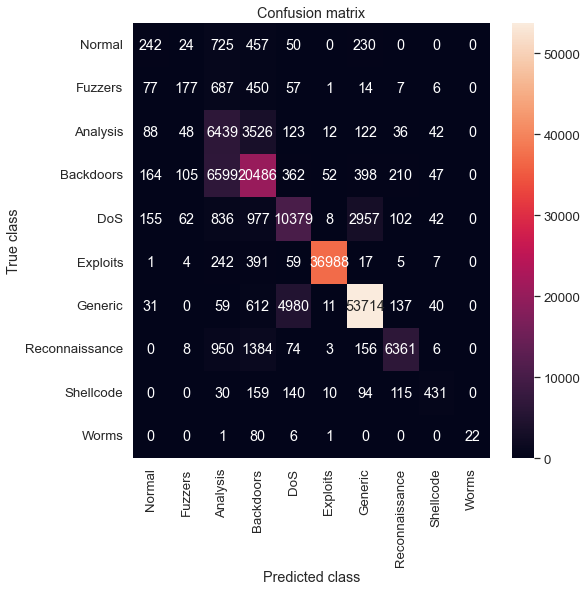

In [27]:
print('training dataset\n')
show_confusion_matrix(tr_df['label'].values, tr_df['predict'].values)

validation dataset



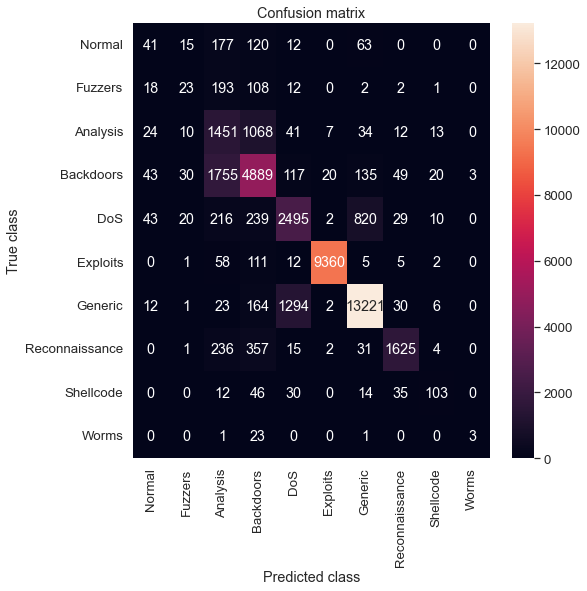

In [28]:
print('validation dataset\n')
show_confusion_matrix(val_df['label'].values, val_df['predict'].values)

testing dataset



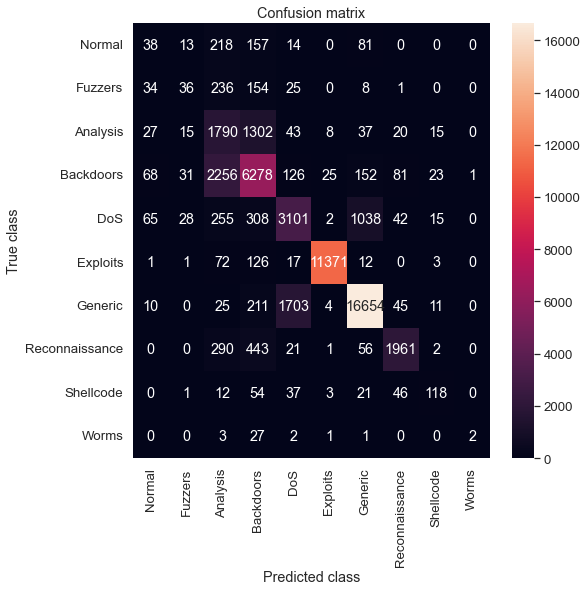

In [29]:
print('testing dataset\n')
show_confusion_matrix(tt_df['label'].values, tt_df['predict'].values)